In [885]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import optimize

In [260]:
def matrix(r,k):
    matrix = []
    col = [0] * k
    for i in range(r):
        matrix.append(col)
    return matrix

In [995]:
#params
T0 = 0
dt = 1/256
T = 1 + dt
rho = 0.8
sigma_0 = 1.2
atmf_vols = [(1/12, 118), (2/12, 128), (0.25, 134), (0.50, 141), (0.75, 145), (1.00, 148), (2.00, 150), (3.00, 151), (4.00, 152),  (5.00, 152), (6.00, 152), (7.00, 152), (8.00, 152), (9.00, 152), (10.00, 152)]
F_0 = 7.5
Paths = 10**4
#time_scale
x = np.linspace(T0,T-dt,int(T/dt))
#greeks
alpha = 5
def alpha_better_skew(T, Tbench = 3, alpha0 = alpha):
    alpha_res = alpha0*((Tbench/T)**0.65)
    return alpha_res
beta = 0.8
#atmf_vols_interpolated
def sigma_0_byT(atmf_vols, t):
    xx = []
    yy = []
    for i in atmf_vols:
        xx.append(i[0])
        yy.append(i[1]/100)
    spline3 = scipy.interpolate.InterpolatedUnivariateSpline(xx, yy, k=3)
    yn3 = spline3(t)
    return yn3
#forwards
fwd_curve = [(1/12,0.0756330723636039), (2/12,0.0766934654909107), (0.25,0.0778104050523594), (0.5,0.0773971156660421), (0.75,0.0770926233856078), (1,0.0753846086995074), (2,0.0692432887688875), (3,0.0692252943061663), (4,0.0685178882143826), (5,0.0693259640667515), (6,0.069375220644603), (7,0.0703013944220464), (8,0.0724733276066309), (9,0.0736041161904691), (10,0.0733657451797859)]
def fwd_curve_interp(fwd_curve, time):
    xx = []
    yy = []
    for i in fwd_curve:
        xx.append(i[0])
        yy.append(i[1])
    spline3 = scipy.interpolate.InterpolatedUnivariateSpline(xx, yy, k=3)
    fwd3 = spline3(time)
    return fwd3
fwd_curve_interp_values = []
for i in time:
    fwd_curve_interp_values.append(fwd_curve_interp(fwd_curve, i))

In [349]:
def sigma_t(t, win, alpha):
    sigma = [sigma_0]
    for i in range(1, len(win)):
        sigma.append(sigma_0 * np.exp(alpha * win[i] - (alpha ** 2) / 2 * x[i]))
    return sigma
'''def Forwards(F0, b, W, sigma, dt):
    F = [F0]
    F_t = F0
    for i in range(1, len(W)):
        F_t = F_t + (sigma[i] * abs(F_t)**b * (W[i] - W[i-1]))*(dt)**0.5
        F.append(F_t)
    return F'''
def Forwards(F0, b, W, sigma, dt):
    F = [F0]
    F_t = F0
    for i in range(1, len(W)):
        F_t = F_t + sigma[i] * abs(F_t)**b * (W[i] - W[i-1]) + 0.5 * b * sigma[i]**2 * abs(F_t)**(2*b - 1)*((W[i] - W[i-1])**2 - dt)
        F.append(F_t)
    return F
sigmas = matrix(Paths, len(x))
fwds = matrix(Paths, len(x))
W1paths = matrix(Paths, len(x))
W2paths = matrix(Paths, len(x))
for j in range(Paths):
    Z1 = np.random.normal(0,1,len(x)-1)*(dt**0.5)
    Z2 = np.random.normal(0,1,len(x)-1)*(dt**0.5)
    W1 = [0]
    for i in range(len(Z1)):
        W1.append(W1[i] + Z1[i])
    W2 = [0]
    for i in range(len(Z2)):
        W2.append((1 - rho**2)**0.5 * (np.cumsum(Z2)[i]) + rho * W1[i+1])
    
    sigmas[j] = sigma_t(x, W2, alpha)
    fwds[j] = Forwards(F_0, beta, W1, sigmas[j], dt)
    W1paths[j] = W1
    W2paths[j] = W2



SABR SDEs:

$d\sigma_t = \alpha \sigma_t dW_{2, t}$

$dF_t = \sigma_t F_t^{\beta} dW_{1, t}$

$W_{2,t} = \sqrt{1-\rho^2} Z_t + \rho W_{1,t}$

Closed form for $\sigma(t)$:
$\sigma_t = \sigma_0  e^{\alpha (W_{2,T} - W_{2,0}) - 0.5 \alpha^2 T}$

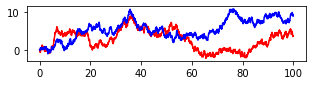

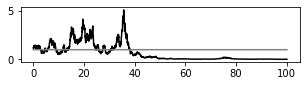

In [104]:
plt.figure(figsize=(5, 1))
plt.plot(x, W1, color = "red") + plt.plot(x, W2, color = "blue")
plt.figure(figsize=(5, 1))
plt.plot(x, sigma_t(x, W2, alpha), color = "black") + plt.plot(x, np.ones(len(x)), 1, color = "gray")

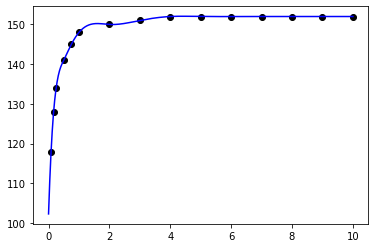

In [763]:
xx = []
yy = []
for i in atmf_vols:
    xx.append(i[0])
    yy.append(i[1])
x = np.linspace(0, 10, 1001)
spline3 = interpolate.InterpolatedUnivariateSpline(xx, yy, k=3)
yn3 = spline3(x)
plt.plot(x, yn3, color = "blue")
plt.scatter(xx,yy, color = "black")
plt.show()

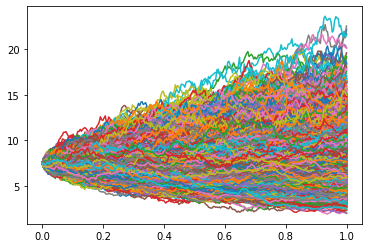

In [345]:
for i in range(Paths):
    plt.plot(x, fwds[i])
plt.show()

In [350]:
f = []
k = []
s = []
for j in range(Paths):
    f.append(fwds[j][-1])
    k.append(np.nanvar(fwds[j])**0.5)
    s.append(np.nansum(sigmas[j])/len(sigmas[j]))
print(sum(f)/Paths)
print(sum(k)/Paths)
print(sum(s)/Paths)

7.89204162587733
0.8440958624090015
1.201340695177988


$\displaystyle dX_{t}= a(X_t) dt+ b(X_t) dW_{t}$. In case of GBM $a(X) = \mu x$ and $b(x) = \sigma x$.

According to $\href{http://www.mathnet.ru/links/9e52f7e92ea9a26fbaa8270d82522ebd/tvp2929.pdf}{Milshtein Method}$:

$X_{{t+\Delta t}} \approx X_{t}+a(X_{t})\Delta t+b(X_{t})\Delta W_{t}+{\frac  {1}{2}}b(X_{t})b'(X_{t})((\Delta W_{t})^{2}-\Delta t)$

In forward SDE $a(F_t) = 0$ and $b(F_t) = \sigma_t F_t^{\beta}$:

$dF_t = \sigma_t F_t^{\beta} dW_{1, t}$

$F_{t+dt} \approx F_t + \sigma F_t^{\beta} (W_{t+dt} - W_t) + \frac{1}{2} \beta \sigma^2 F_t^{2\beta-1} ((W_{t+dt} - W_t)^2 - dt)$

In [1129]:
#params
rho = 0.7
atmf_vols = [(1/12, 118), (2/12, 128), (0.25, 134), (0.50, 141), (0.75, 145), (1.00, 148), (2.00, 150), (3.00, 151), (4.00, 152),  (5.00, 152), (6.00, 152), (7.00, 152), (8.00, 152), (9.00, 152), (10.00, 152)]
#greeks
alpha = 1.5
def alpha_better_skew(T, Tbench = 3, alpha0 = alpha):
    #alpha_res = alpha0*((Tbench/T)**0.5)
    alpha_res = alpha0
    return alpha_res
beta = 0.5
#atmf_vols_interpolated
def sigma_0_byT(atmf_vols, t):
    xx = []
    yy = []
    for i in atmf_vols:
        xx.append(i[0])
        yy.append(i[1]/100)
    spline3 = scipy.interpolate.InterpolatedUnivariateSpline(xx, yy, k=3)
    yn3 = spline3(t)
    return yn3
#forwards
fwd_curve = [(1/12,0.0756330723636039), (2/12,0.0766934654909107), (0.25,0.0778104050523594), (0.5,0.0773971156660421), (0.75,0.0770926233856078), (1,0.0753846086995074), (2,0.0692432887688875), (3,0.0692252943061663), (4,0.0685178882143826), (5,0.0693259640667515), (6,0.069375220644603), (7,0.0703013944220464), (8,0.0724733276066309), (9,0.0736041161904691), (10,0.0733657451797859)]
def fwd_curve_interp(fwd_curve, time):
    xx = []
    yy = []
    for i in fwd_curve:
        xx.append(i[0])
        yy.append(i[1]*100)
    spline3 = scipy.interpolate.InterpolatedUnivariateSpline(xx, yy, k=3)
    fwd3 = spline3(time)
    return fwd3
fwd_curve_interp_values = []
for i in time:
    fwd_curve_interp_values.append(fwd_curve_interp(fwd_curve, i))

In [1130]:
#SABR by Hagan
def sigma_sabr(t, T, K, f, alpha, rho, sigma0, beta):
    tau = T - t
    #f = abs(f)
    fk = (f*K)**(1-beta)
    z = alpha / sigma0 * fk**0.5 * np.log(f/K)
    x=np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    if K == f:
        numerator = sigma0*(1+tau*( (1-beta)**2/24 * sigma0**2/(f**(2-2*beta)) + 1/4*rho*beta*alpha*sigma0/(f**(1-beta)) + (2-3*rho**2)/24*alpha**2) )
        denominator = f**(1-beta)
        sigma=numerator/denominator
    else:
        if alpha == 0:
            sigma = sigma0
        else:
            numerator = 1+tau*( (1-beta)**2/24 * sigma0**2/(fk) + 1/4*rho*beta*alpha*sigma0/(fk**0.5) + (2-3*rho**2)/24*alpha**2) 
            denominator = fk**0.5 * (1+(1-beta)**2/24*(np.log(f/K))**2 + (1-beta)**4/1920 * (np.log(f/K))**4)
            sigma=sigma0*(z/x)*numerator/denominator
    return sigma

In [1131]:
#Calibrate atmf vols: find sigma0 such as atmf(sabr) = atmf_vols
fwd = fwd_curve_interp_values
Tenors = np.arange(0.1,10.1,0.1)
vol_y = list()
sigma_output = list()
for j in range(len(Tenors)):   
    vol_y.append(sigma_0_byT(atmf_vols, Tenors[j]))
    def func(s):
        return vol_y[j] - sigma_sabr(t=0,T=Tenors[j],K=fwd[j],f=fwd[j],alpha=alpha_better_skew(Tenors[j]),rho=rho,sigma0 = s,beta=beta)
    sigma_output.append(optimize.fsolve(func, vol_y[j]))

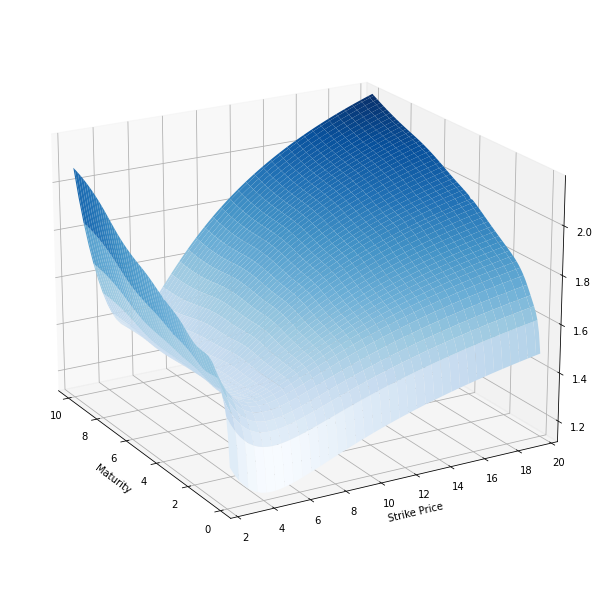

In [1132]:
Tenors = np.arange(0.1,10.1,0.1)
Strikes = np.arange(2.25, 20.25, 0.25)

sigma_sabr_M = np.zeros((len(Tenors), len(Strikes)))

for j in range(len(Tenors)):
    for i in range(len(Strikes)):
        sigma_sabr_M[j][i] = sigma_sabr(t=0,T=Tenors[j],K=Strikes[i],f=fwd[j],alpha=alpha_better_skew(Tenors[j]),rho=rho,sigma0=sigma_output[j],beta=beta)

def iv(T,K):
    T = int((T - 0.1)*10)
    K = int((K - 2.25)*4)
    return sigma_sabr_M[T][K]
impliedvol=np.vectorize(iv)

Tenors, Strikes = np.meshgrid(Tenors, Strikes)

Z = impliedvol(Tenors, Strikes)

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.plot_surface(Tenors,Strikes,Z, cmap = "Blues")
#ax.view_init(60,45)
plt.xlabel('Maturity')
plt.ylabel('Strike Price')
#plt.show()
ax.set_ylim(20,2)
ax.view_init(20, 150)
plt.show()

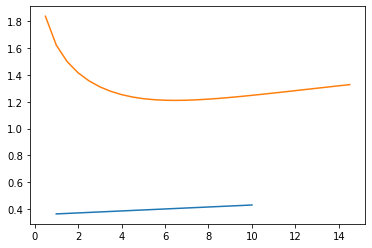

In [769]:
Tenors = np.linspace(1,10,10)
Strikes = np.linspace(0.5,14.5,29)
vols_T = []
for i in Tenors:
    vols_T.append(sigma_sabr(t=0,T=i,K=7.5,f=7.5,alpha=0.45,rho=0.5,sigma0=1.2,beta=0.4))
vols_smile = []
for i in Strikes:
    vols_smile.append(sigma_sabr(t=0,T=2,K=i,f=7.5,alpha=1,rho=0.1,sigma0=1,beta=1))
plt.plot(Tenors, vols_T)
plt.plot(Strikes, vols_smile)

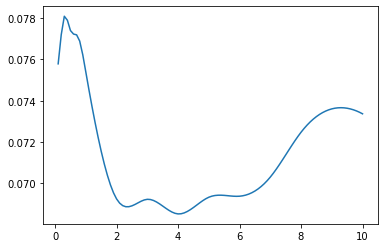

In [1037]:
plt.plot(time,  fwd_curve_interp_values)

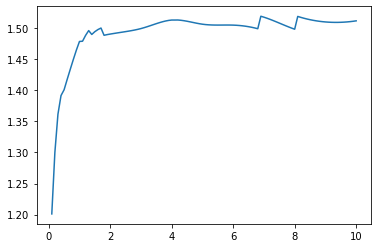

In [1076]:
Tenors = np.arange(0.1,10.1,0.1)
time = Tenors.copy()
atms = []
for i in range(len(time)):
    atms.append(iv(time[i], fwd[i]))
plt.plot(time,  atms)

In [1029]:
np.arange(0.25, 20.25, 0.25)

array([ 0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
        2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,
        4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,
        7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
        9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25,
       11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 ,
       13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75,
       16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  ,
       18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ])